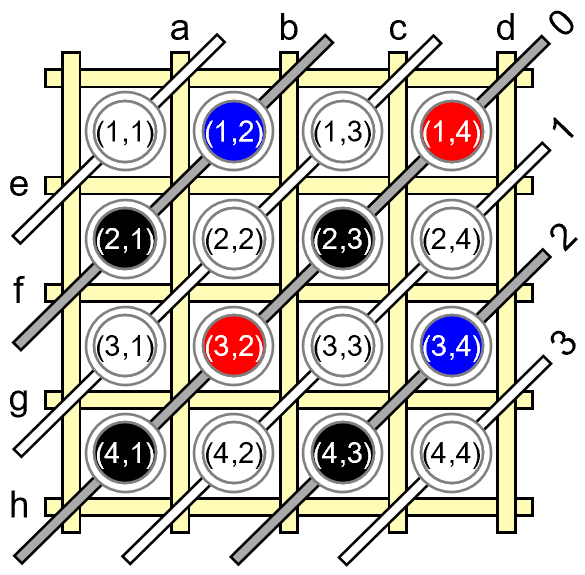

In [1]:
import math
import numpy as np
from string import ascii_lowercase


L = 4
Ntot = 2*L - 1

# generating the coordinates of all sites in the unit cell
site_list = [(j, k) for j in range(1, L + 1) for k in range(1, L + 1)]

# assigning the plunger gates to each site
site_to_plunger = {(j, k): i for i in range(Ntot + 1) for j in range(1, L + 1) for k in range(1, L + 1) if j + k == i + 1}

# converting the character barrier indices to numbers
barrier_to_number = {ascii_lowercase[j]: j + 1 for j in range(2 * L)}

# modulo with offset 1 is used for periodic boundary conditions
def mod(coord, L):
  return coord - L * math.floor((coord - 1) / L)

# number of electrons at site
def n(E_conf, site):
  return E_conf.count(site)

# abstract plunger gate voltage value at site
def P(plunger_list, site):
  full_plunger_list = plunger_list[-(L-1):] + plunger_list
  return full_plunger_list[site_to_plunger[site] - 1]

# function for comparing abstract plunger gate voltages at site_1 and site_2
def lowerOnSite(plunger_list, site_1, site_2):
    return min([site_1, site_2], key=lambda site: P(plunger_list, site))

# coordinates of electrons located on the left side of a (vertical) barrier
def neighboringLeft(E_conf, barrier):
  beta = barrier_to_number[barrier[0]]
  return [e for e in E_conf if e[1] == beta]

# coordinates of electrons located on the right side of a (vertical) barrier
def neighboringRight(E_conf, barrier):
  beta = barrier_to_number[barrier[0]]
  return [e for e in E_conf if e[1] == mod(beta + 1, L)]

# coordinates of electrons located up above a (horizontal) barrier
def neighboringUp(E_conf, barrier):
  beta = barrier_to_number[barrier[0]] - L
  return [e for e in E_conf if e[0] == beta]

# coordinates of electrons located down below a (horizontal) barrier
def neighboringDown(E_conf, barrier):
  beta = barrier_to_number[barrier[0]] - L
  return [e for e in E_conf if e[0] == mod(beta + 1, L)]

# coordinates of all electrons neighboring a barrier
def neighboringElectrons(E_conf, barrier):
  beta = barrier_to_number[barrier[0]]
  if beta <= L:
      return sorted(neighboringLeft(E_conf, barrier) + neighboringRight(E_conf, barrier))
  else:
      return sorted(neighboringUp(E_conf, barrier) + neighboringDown(E_conf, barrier))

# coordinates of electrons not neighboring any barrier that is activated
def notInfluencedElectrons(E_conf, barriers):
  influenced_electrons = [e for b in barriers for e in neighboringElectrons(E_conf, b)]
  return sorted([e for e in E_conf if e not in influenced_electrons])



# implementing the requirements for compatibility
def checkConditions(C0, barrier, new_plungers):
  E0, P0 = C0
  beta = barrier_to_number[barrier[0]]
  P1 = new_plungers

  if beta <= L:
    conditions = [
        all(sum(n(E0, (j, k)) for k in [beta, mod(beta + 1, L)]) <= 1 for j in range(1, L + 1)),
        all(P(P0, (j, beta)) != P(P0, (j, mod(beta + 1, L))) for j in range(1, L + 1)),
        all(lowerOnSite(P0, e, (e[0], mod(e[1] + 1, L))) == e for e in neighboringLeft(E0, barrier)),
        all(lowerOnSite(P0, e, (e[0], mod(e[1] - 1, L))) == e for e in neighboringRight(E0, barrier)),
        all(P(P1, (j, beta)) != P(P1, (j, mod(beta + 1, L))) for j in range(1, L + 1))
    ]
  else:
    beta -= L
    conditions = [
        all(sum(n(E0, (j, k)) for j in [beta, mod(beta + 1, L)]) <= 1 for k in range(1, L + 1)),
        all(P(P0, (beta, k)) != P(P0, (mod(beta + 1, L), k)) for k in range(1, L + 1)),
        all(lowerOnSite(P0, e, (mod(e[0] + 1, L), e[1])) == e for e in neighboringUp(E0, barrier)),
        all(lowerOnSite(P0, e, (mod(e[0] - 1, L), e[1])) == e for e in neighboringDown(E0, barrier)),
        all(P(P1, (beta, k)) != P(P1, (mod(beta + 1, L), k)) for k in range(1, L + 1))
    ]
  return all(conditions)


# checking that a shifts is compatible with a given configuration C0
def compatibility(C0, shift):
    barriers = shift[0]
    P1 = shift[1]

    if len(barriers) != 1:
        barriers_num = sorted([barrier_to_number[b] for b in barriers])
        return min(np.diff(barriers_num)) > 1 and all(checkConditions(C0, b, P1) for b in barriers)
    else:
        return checkConditions(C0, barriers, P1)


# action of a shift on a given configuration C0
def move(C0, shift):
    E0 = C0[0]
    barriers = shift[0]
    P1 = shift[1]

    if compatibility(C0, shift):
        if all(barrier_to_number[b] <= L for b in barriers):
            new_pos = notInfluencedElectrons(E0, barriers) + [lowerOnSite(P1, (e[0], barrier_to_number[b]), (e[0], mod(barrier_to_number[b] + 1, L))) for b in barriers for e in neighboringElectrons(E0, b)]
            return (sorted(new_pos), P1)
        else:
            new_pos = notInfluencedElectrons(E0, barriers) + [lowerOnSite(P1, (barrier_to_number[b] - L, e[1]), (mod(barrier_to_number[b] - L + 1, L), e[1])) for b in barriers for e in neighboringElectrons(E0, b)]
            return (sorted(new_pos), P1)
    else:
        return "incompatible shift"

In [31]:
import ast

# importing all shifts and configurations

f = open("shiftsZ.txt", "r")
all_shifts_Z = []
for s in f:
  all_shifts_Z.append(ast.literal_eval(s))
f.close()

f = open("configurationsZ.txt", "r")
all_configurations_Z = []
for c in f:
  all_configurations_Z.append(ast.literal_eval(c))
f.close()


f = open("shiftsX.txt", "r")
all_shifts_X = []
for s in f:
  all_shifts_X.append(ast.literal_eval(s))
f.close()

f = open("configurationsX.txt", "r")
all_configurations_X = []
for c in f:
  all_configurations_X.append(ast.literal_eval(c))
f.close()

In [34]:
'''
Z-cyle, checking that all shifts compatible with their previous configuration and move the grid to the subsequent configuration:
idle configuration -> rightward triangle configuration -> idle configuration -> leftward triangle configuration -> idle configuration
'''

for i in range(len(all_shifts_Z)):
  print(move(all_configurations_Z[i], all_shifts_Z[i]) == all_configurations_Z[i+1])

True
True
True
True


In [35]:
'''
X-cyle, checking that all shifts compatible with their previous configuration and move the grid to the subsequent configuration
'''

for i in range(len(all_shifts_X)):
  print(move(all_configurations_X[i], all_shifts_X[i]) == all_configurations_X[i+1])

True
True
True
True
